# 1. data import & preprocessing 

In [1]:
import numpy as np
import pandas as pd

### 1) dataset 불러오기
* data50: train set
* data25: test set

In [2]:
data25 = pd.read_csv("C:/Users/ishon/OneDrive/바탕 화면/compas/model/data/feature25.csv")
data50 = pd.read_csv("C:/Users/ishon/OneDrive/바탕 화면/compas/model/data/feature50.csv")

data25['is_bump40'] = data25['shortest_bump_dist'] < 40
data50['is_bump40'] = data50['shortest_bump_dist'] < 40

data25['is_sidewalk25'] = data25['shortest_sidewalk_dist'] < 25
data50['is_sidewalk25'] = data50['shortest_sidewalk_dist'] < 25

## 2) 사용할 변수 선언

In [3]:
col = {"x_common": ['overspeed_cam_count100', 'floating_pop_count50','car_count1000', 'child_count1000', 
                  'elem_kinder_count400','num_cram_school_count400', 
                  'shortest_cross_dist','shortest_traffic_signal_dist',],
       "x_25" : ['is_bump40', 'parking_count25','is_sidewalk25', 'barrier_nearby_count25',
                   'chaos1_nearby_count25', 'width_nearby_count25','cross_road_nearby_count25',
                   ],
       "x_50" : ['is_bump40', 'parking_count25','is_sidewalk25', 'barrier_nearby_count25',
                   'chaos1_nearby_count25', 'width_nearby_count25','cross_road_nearby_count25'],
       "y_25" : 'accident_count12.5',
       "y_50" : 'accident_count25'}

xy50 = data50[col["x_common"] + col["x_50"] +[col['y_50']]].astype(float)
xy25 = data25[col["x_common"] + col["x_25"] +[col['y_25']]].astype(float)

xy50[col['y_50']] = (xy50[col['y_50']] > 0).astype(float)
xy25[col['y_25']] = (xy25[col['y_25']] > 0).astype(float)

## 3) 사전에 진행한 cluster data 불러오기

In [4]:
kmeans50 = pd.read_csv("C:/Users/ishon/OneDrive/바탕 화면/compas/model/data/kmeans_cluster50.csv")
kmeans25 = pd.read_csv("C:/Users/ishon/OneDrive/바탕 화면/compas/model/data/kmeans_cluster25.csv")

In [5]:
print(xy50.shape)
print(kmeans50.shape)
print(xy25.shape)
print(kmeans25.shape)

(3912, 16)
(3912, 1)
(7636, 16)
(7636, 1)


## 4) dataset 합치기

In [6]:
xy50=pd.concat([xy50, kmeans50], axis=1)
xy50.rename(columns={'0':'cluster'}, inplace=True)

xy25=pd.concat([xy25, kmeans25], axis=1)
xy25.rename(columns={'0':'cluster'}, inplace=True)

## 5) 사고 방지 장치 데이터 삭제 (도로 자체만의 특성만 반영하기 위해)

In [7]:
xy_train=xy50.drop(['overspeed_cam_count100', 'is_bump40'], axis=1)
xy_test=xy25.drop(['overspeed_cam_count100', 'is_bump40'], axis=1)

## 6) 열 이름 통일 (열 이름이 다르면, model train 후 predict할 때 오류 뜸)

In [8]:
xy_train.rename(columns={'parking_count25':'parking_count', 'is_sidewalk25':'is_sidewalk',
                    'barrier_nearby_count25':'barrier_nearby_count', 'chaos1_nearby_count25':'chaos1_nearby_count',
                     'width_nearby_count25':'width_nearby_count', 'cross_road_nearby_count25':'cross_road_nearby_count',
                     'accident_count25':'accident_count'},inplace=True)
xy_test.rename(columns={'parking_count25':'parking_count', 'is_sidewalk25':'is_sidewalk',
                    'barrier_nearby_count25':'barrier_nearby_count', 'chaos1_nearby_count25':'chaos1_nearby_count',
                     'width_nearby_count25':'width_nearby_count', 'cross_road_nearby_count25':'cross_road_nearby_count',
                     'accident_count12.5':'accident_count'},inplace=True)

## 7) categorical 변수 처리

In [9]:
xy_train['cluster']=xy_train['cluster'].astype('category')
xy_test['cluster']=xy_test['cluster'].astype('category')

In [10]:
xy_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3912 entries, 0 to 3911
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   floating_pop_count50          3912 non-null   float64 
 1   car_count1000                 3912 non-null   float64 
 2   child_count1000               3912 non-null   float64 
 3   elem_kinder_count400          3912 non-null   float64 
 4   num_cram_school_count400      3912 non-null   float64 
 5   shortest_cross_dist           3912 non-null   float64 
 6   shortest_traffic_signal_dist  3912 non-null   float64 
 7   parking_count                 3912 non-null   float64 
 8   is_sidewalk                   3912 non-null   float64 
 9   barrier_nearby_count          3912 non-null   float64 
 10  chaos1_nearby_count           3912 non-null   float64 
 11  width_nearby_count            3912 non-null   float64 
 12  cross_road_nearby_count       3912 non-null   fl

In [11]:
xy_test['cluster'].value_counts()

2    3062
0    2979
3    1143
1     452
Name: cluster, dtype: int64

In [12]:
xy_train=pd.get_dummies(xy_train)
xy_test=pd.get_dummies(xy_test)

## 8) X, y split

In [13]:
X_train=xy_train.drop(['accident_count'], axis=1)
y_train=xy_train['accident_count']

X_test=xy_test.drop(['accident_count'], axis=1)
y_test=xy_test['accident_count']

# 2. Model - XGB Classifier

In [14]:
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score
from imblearn.over_sampling import SMOTE # unbalanced dataset을 학습시키기 위해, smote 사용하여 oversampling(train set만)

## 1) smote를 이용하여 oversampling (불균형 data를 조정)

In [15]:
sm = SMOTE()
X_resampled, y_resampled = sm.fit_sample(X_train, y_train)

## 2) Bayesian opt

In [16]:
import warnings
import xgboost as xgb
warnings.filterwarnings(action='ignore') 
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

In [17]:
xgtrain = xgb.DMatrix(data=X_resampled, label=y_resampled)

def xgb_eval(n_estimators, learning_rate, max_depth, min_child_weight, num_leaves, subsample, colsample_bytree, gamma):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'n_estimators': int(round(n_estimators)),
        'learning_rate': 0.1,
        'max_depth' : int(round(max_depth)),
        'min_child_weight': int(round(min_child_weight)),
        'num_leaves': int(round(num_leaves)),
        'subsample': 1,
        'colsample_bytree': 1,
        'gamma': 0,
        'verbosity': 0}
    
    cv_result = xgb.cv(params=params,
                       dtrain=xgtrain,
                       nfold=5)
    return cv_result['test-auc-mean'].max()

In [18]:
xgbBO = BayesianOptimization(xgb_eval, {'n_estimators': (100, 3000),
                                        'learning_rate': (0.01, 0.1),
                                        'max_depth': (1, 10),
                                        'min_child_weight': (1, 10),
                                        'num_leaves': (20, 40),
                                        'subsample': (0.5, 1),
                                        'colsample_bytree': (0.5, 1),
                                        'gamma': (0, 0.1)})

xgbBO.maximize(init_points=10, n_iter=100)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.9534   |  0.8405   |  0.0696   |  0.06242  |  4.995    |  4.531    |  2.395e+0 |  33.63    |  0.8416   |
|  2        |  0.9685   |  0.8247   |  0.000965 |  0.04844  |  7.673    |  8.609    |  1.176e+0 |  39.42    |  0.5521   |
|  3        |  0.8282   |  0.9601   |  0.01004  |  0.08095  |  1.189    |  8.334    |  2.353e+0 |  21.73    |  0.5222   |
|  4        |  0.9625   |  0.8935   |  0.08415  |  0.06405  |  5.586    |  3.421    |  2.063e+0 |  23.38    |  0.5103   |
|  5        |  0.9376   |  0.5482   |  0.0871   |  0.01196  |  4.351    |  3.702    |  2.187e+0 |  28.99    |  0.5852   |
|  6        |  0.9746   |  0.7363   |  0.01923  |  0.07808  |  8.69     |  5.99     |  377.2    |  28.17    |  0.8601   |
|  7        |  0.9728   

|  41       |  0.9597   |  0.6219   |  0.08578  |  0.04091  |  6.33     |  9.086    |  1.21e+03 |  39.67    |  0.8666   |
|  42       |  0.8282   |  0.6015   |  0.003428 |  0.01519  |  1.494    |  1.095    |  1.2e+03  |  34.05    |  0.7751   |
|  43       |  0.9661   |  0.8318   |  0.004556 |  0.05946  |  7.078    |  9.254    |  1.209e+0 |  29.02    |  0.9396   |
|  44       |  0.9746   |  0.8988   |  0.08418  |  0.08618  |  8.836    |  5.689    |  1.217e+0 |  33.05    |  0.8081   |
|  45       |  0.9758   |  0.5391   |  0.06808  |  0.05357  |  8.366    |  2.15     |  1.218e+0 |  22.1     |  0.524    |
|  46       |  0.9706   |  1.0      |  0.0      |  0.1      |  10.0     |  10.0     |  2.053e+0 |  20.0     |  1.0      |
|  47       |  0.9661   |  0.6679   |  0.03507  |  0.08196  |  6.694    |  9.158    |  1.226e+0 |  25.91    |  0.5293   |
|  48       |  0.9812   |  0.762    |  0.000578 |  0.04523  |  9.629    |  1.514    |  1.227e+0 |  39.55    |  0.5592   |
|  49       |  0.8677   

|  82       |  0.9807   |  1.0      |  0.1      |  0.1      |  10.0     |  1.0      |  385.6    |  26.75    |  0.5      |
|  83       |  0.9706   |  0.8244   |  0.06097  |  0.06347  |  9.838    |  9.955    |  1.204e+0 |  32.34    |  0.7946   |
|  84       |  0.9751   |  0.6152   |  0.05056  |  0.04988  |  9.922    |  6.512    |  2.34e+03 |  37.34    |  0.609    |
|  85       |  0.9771   |  0.6306   |  0.005236 |  0.09059  |  8.807    |  3.233    |  2.286e+0 |  27.15    |  0.6843   |
|  86       |  0.9679   |  0.9153   |  0.001276 |  0.05028  |  7.006    |  7.394    |  2.277e+0 |  22.33    |  0.5277   |
|  87       |  0.9713   |  0.6286   |  0.002625 |  0.09605  |  8.805    |  8.593    |  2.282e+0 |  34.21    |  0.8838   |
|  88       |  0.8677   |  0.8272   |  0.03251  |  0.06162  |  2.41     |  1.798    |  2.27e+03 |  29.66    |  0.8477   |
|  89       |  0.9706   |  1.0      |  0.0      |  0.01     |  10.0     |  10.0     |  2.312e+0 |  31.14    |  0.5      |
|  90       |  0.9197   

In [19]:
xgbBO.max

{'target': 0.9812018,
 'params': {'colsample_bytree': 0.7619756011778948,
  'gamma': 0.0005784746201050406,
  'learning_rate': 0.04522902591974105,
  'max_depth': 9.629229803525678,
  'min_child_weight': 1.5144432418096145,
  'n_estimators': 1226.8217028326512,
  'num_leaves': 39.54503468986303,
  'subsample': 0.5591680752151498}}

## 3) f1 score와 confusion matrix 살펴보기

In [20]:
BO_params=xgbBO.max['params']

xgb_model = XGBClassifier(params=BO_params)
xgb_model.fit(X_resampled, y_resampled)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              params={'colsample_b...
                      'gamma': 0.0005784746201050406,
                      'learning_rate': 0.04522902591974105,
                      'max_depth': 9.629229803525678,
                      'min_child_weight': 1.5144432418096145,
                      'n_estimators': 1226.8217028326512,
                      'num_leaves': 39.54503468986303,
                      'subsample': 0.5591680752151498},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=

In [21]:
xgb_pred = xgb_model.predict(X_test)

In [22]:
print(f1_score(y_test, xgb_pred))
confusion_matrix(y_test, xgb_pred)

0.466557911908646


array([[7166,  275],
       [  52,  143]], dtype=int64)

In [23]:
print(f1_score(y_test, xgb_pred, average=None))

[0.97769288 0.46655791]


## 4) ROC curve 그려보기

In [24]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = xgb_model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

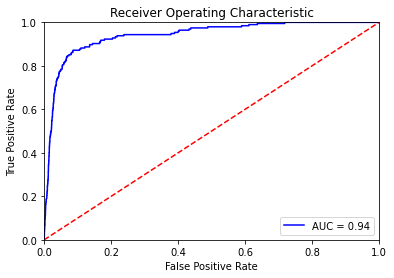

In [25]:
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 5) cut-off 조정해보면서, Model 성능 재확인

In [26]:
xgb_pred2 = (xgb_model.predict_proba(X_test)[:,1]>=0.5).astype(int)
print('f1 score:', f1_score(y_test, xgb_pred2))
    
confusion_matrix(y_test, xgb_pred2)

f1 score: 0.466557911908646


array([[7166,  275],
       [  52,  143]], dtype=int64)

## 6) feature importance

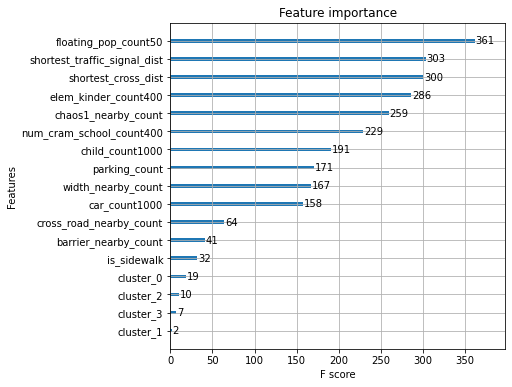

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(6, 6))
plot_importance(xgb_model, ax=ax)

# 3. 결과- 위험지역 뽑아보기

In [33]:
xgb_pred_prob = xgb_model.predict_proba(X_test)

danger_xgb=pd.DataFrame(xgb_pred_prob)
danger_xgb.columns=['No_xgb', 'Yes_xgb']

In [34]:
danger_xgb=pd.concat([data25, danger_xgb], axis=1)
danger_xgb_all=danger_xgb.sort_values(by=['Yes_xgb'], ascending=False)[0:195] #그냥 상위 100개

In [35]:
danger_xgb_without=danger_xgb[danger_xgb['overspeed_cam_count100']==0]
danger_xgb_without=danger_xgb_without.sort_values(by=['Yes_xgb'], ascending=False)[0:195] #카메라 없는 곳 상위 100개

In [36]:
import geopandas as gpd
import json
import folium
from folium import plugins

In [37]:
osan=gpd.read_file("C:/Users/ishon/OneDrive/바탕 화면/SIG_202005/SIG.shp")
osan=osan[osan["SIG_ENG_NM"]=="Osan-si"]
center = (37.1623799231016, 127.05436890115905)
style5 = {'fillColor': 'skyblue', 'color': 'skyblue'}

map_xgb_danger = folium.Map(location=center, zoom_start=12, width=900, height=700, control_scale=True)

#osan
osan_region = plugins.FeatureGroupSubGroup(map_xgb_danger, 'osan region')
map_xgb_danger.add_child(osan_region)
folium.GeoJson(osan, style_function=lambda x:style5).add_to(osan_region)

fg = folium.FeatureGroup(name='groups')
map_xgb_danger.add_child(fg)

g1 = plugins.FeatureGroupSubGroup(fg, 'group1')
map_xgb_danger.add_child(g1)

g2 = plugins.FeatureGroupSubGroup(fg, 'group2')
map_xgb_danger.add_child(g2)

danger_xgb_all.apply(lambda row: folium.CircleMarker(location=[row['lat'], row['lon']],
                                                radius=2, color='blue').add_to(g1), axis=1)

danger_xgb_without.apply(lambda row: folium.CircleMarker(location=[row['lat'], row['lon']],
                                               radius=2, color='red').add_to(g2), axis=1)

folium.LayerControl(collapsed=False).add_to(map_xgb_danger)
map_xgb_danger

# 4. 최종 위험도 출력

In [38]:
classic=pd.read_csv('classic_opt_set.csv')
classic.columns

Index(['Unnamed: 0', 'floating_pop_count50', 'elem_kinder_count400',
       'num_cram_school_count400', 'parking_count25', 'width_nearby_count25',
       'cross_road_nearby_count25', 'lat', 'lon', 'overspeed_cam_count100',
       'is_cross50', 'is_traffic_signal50', 'is_bump40',
       'numberSchoolZone_count400', 'cluster', 'extra50', 'danger', 'index'],
      dtype='object')

In [39]:
modern=classic.drop(['danger'], axis=1)

In [40]:
modern['danger']=xgb_pred_prob[:,1]

In [41]:
modern

,Unnamed: 0,floating_pop_count50,elem_kinder_count400,num_cram_school_count400,parking_count25,width_nearby_count25,cross_road_nearby_count25,lat,lon,overspeed_cam_count100,is_cross50,is_traffic_signal50,is_bump40,numberSchoolZone_count400,cluster,extra50,index,danger
0,0,0.327047,0.032258,0.078341,0.0,0.111111,0.3,37.149281,127.061509,0,True,True,False,0,2,0,0,0.969011
1,1,0.424811,0.032258,0.078341,0.0,0.250000,0.4,37.149503,127.061615,0,True,True,False,0,2,0,1,0.621932
2,2,0.305142,0.032258,0.119816,0.0,0.333333,0.3,37.149617,127.061865,0,True,True,False,0,2,0,2,0.034020
3,3,0.357320,0.032258,0.018433,0.0,0.333333,0.3,37.149433,127.060957,0,True,True,False,0,0,0,3,0.009923
4,4,0.398514,0.032258,0.078341,0.0,0.333333,0.3,37.149457,127.061237,0,True,True,False,0,2,0,4,0.131081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7631,7631,0.054380,0.129032,0.096774,0.0,0.166667,0.0,37.169517,127.060176,0,False,False,False,0,2,0,8851,0.005556
7632,7632,0.057806,0.129032,0.096774,0.0,0.000000,0.0,37.169633,127.060430,0,False,False,False,0,2,0,8852,0.000804
7633,7633,0.025602,0.129032,0.096774,0.0,0.000000,0.0,37.169753,127.060416,0,False,False,False,1,2,0,8853,0.000839
7634,7634,0.053524,0.129032,0.096774,0.0,0.000000,0.0,37.169860,127.060214,0,False,False,False,1,2,0,8854,0.001076


In [42]:
modern.to_csv('C:/Users/ishon/OneDrive/바탕 화면/modern_opt_set_BO.csv')